# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [2]:
# !pip install finance-datareader

In [3]:
import FinanceDataReader as fdr

In [4]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [5]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-02-09,74300,74700,74000,74700,9699122,0.016327
2022-02-10,75600,75800,74700,75400,17746033,0.009371
2022-02-11,75000,75500,74600,74900,12205407,-0.006631
2022-02-14,74400,74500,73100,73700,13993255,-0.016021
2022-02-15,74100,74200,73100,73700,9239742,0.000000


**미국 주식 데이터**도 가져올 수 있습니다.

In [6]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [7]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-02-08,174.83,171.73,175.35,171.43,74830000.0,0.0185
2022-02-09,176.28,176.05,176.65,174.90,66500000.0,0.0083
2022-02-10,172.12,174.14,175.48,171.55,88400000.0,-0.0236
2022-02-11,168.64,172.33,173.08,168.04,98670000.0,-0.0202
2022-02-14,168.88,167.37,169.58,166.56,85990000.0,0.0014


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [9]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [10]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [11]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [12]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [13]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니, 

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [14]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [15]:
stock = fdr.DataReader(STOCK_CODE)

In [16]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-01-06,777,791,771,784,409200,NaN
1998-01-07,784,820,784,799,456870,0.019133
1998-01-08,800,853,786,844,558940,0.056320
1998-01-09,831,853,820,839,606050,-0.005924
1998-01-10,853,904,844,904,355440,0.077473


In [17]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-02-09,74300,74700,74000,74700,9699122,0.016327
2022-02-10,75600,75800,74700,75400,17746033,0.009371
2022-02-11,75000,75500,74600,74900,12205407,-0.006631
2022-02-14,74400,74500,73100,73700,13993255,-0.016021
2022-02-15,74100,74200,73100,73700,9239742,0.000000


In [18]:
stock.index

DatetimeIndex(['1998-01-06', '1998-01-07', '1998-01-08', '1998-01-09',
               '1998-01-10', '1998-01-12', '1998-01-13', '1998-01-14',
               '1998-01-15', '1998-01-16',
               ...
               '2022-01-28', '2022-02-03', '2022-02-04', '2022-02-07',
               '2022-02-08', '2022-02-09', '2022-02-10', '2022-02-11',
               '2022-02-14', '2022-02-15'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [19]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [20]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-01-06,777,791,771,784,409200,NaN,1998,1,6
1998-01-07,784,820,784,799,456870,0.019133,1998,1,7
1998-01-08,800,853,786,844,558940,0.056320,1998,1,8
1998-01-09,831,853,820,839,606050,-0.005924,1998,1,9
1998-01-10,853,904,844,904,355440,0.077473,1998,1,10


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


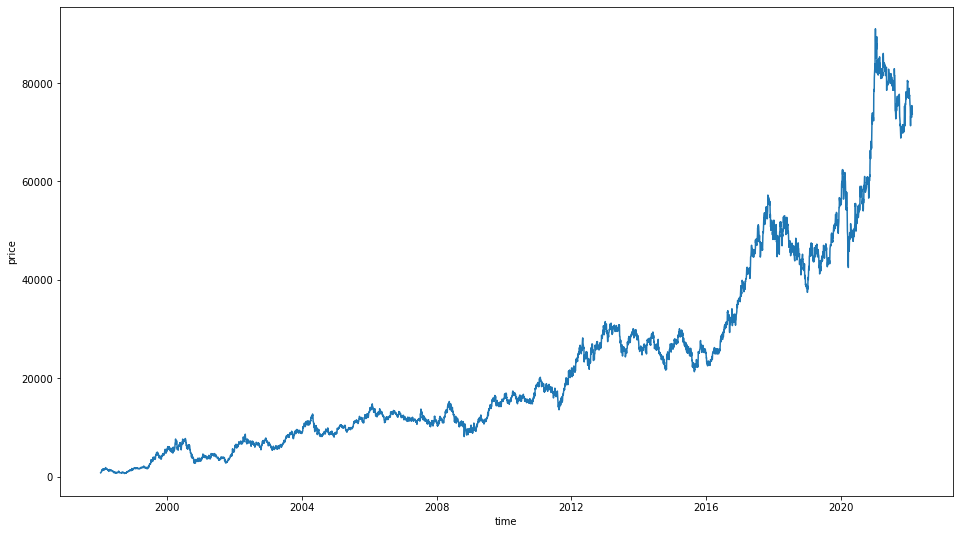

In [21]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


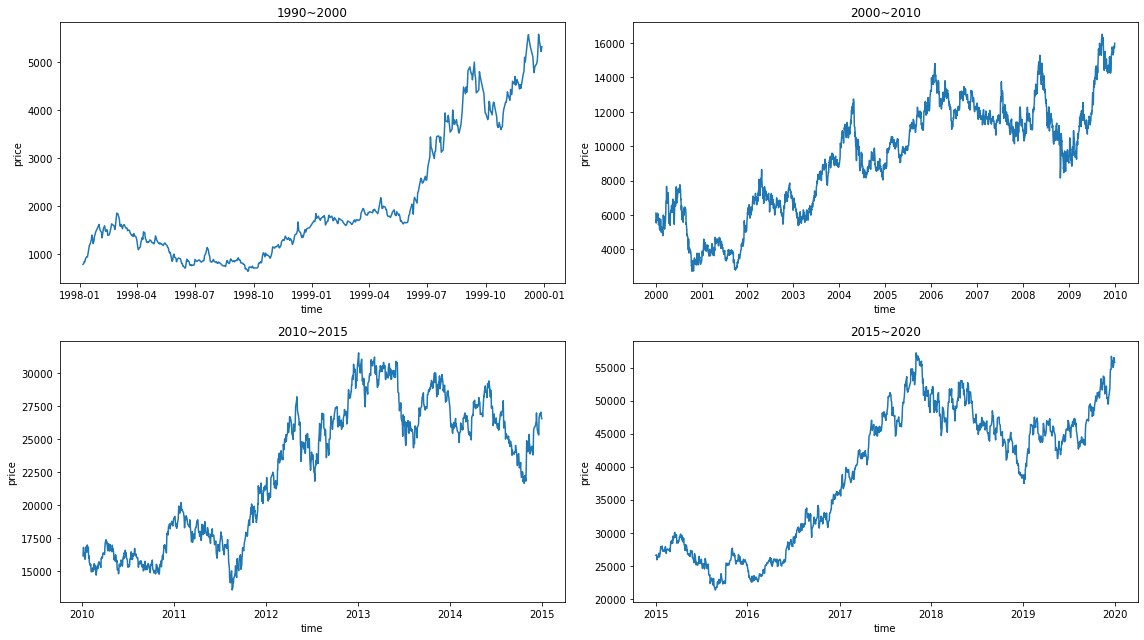

In [22]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.00860465, 0.00817149, 0.00861453, 0.00161572, 0.00453125],
       [0.00868217, 0.00847107, 0.00875978, 0.00178172, 0.00505912],
       [0.00885936, 0.00881198, 0.00878212, 0.00227972, 0.00618939],
       ...,
       [0.83056478, 0.77995868, 0.83351955, 0.82182776, 0.13515584],
       [0.82392027, 0.7696281 , 0.81675978, 0.80854784, 0.15495346],
       [0.82059801, 0.76652893, 0.81675978, 0.80854784, 0.10231573]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [24]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [27]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [28]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [29]:
x_train

,Open,High,Low,Volume
0,0.008605,0.008171,0.008615,0.004531
1,0.008682,0.008471,0.008760,0.005059
2,0.008859,0.008812,0.008782,0.006189
3,0.009203,0.008812,0.009162,0.006711
4,0.009446,0.009339,0.009430,0.003936
...,...,...,...,...
4795,0.462680,0.440909,0.466592,0.003149
4796,0.460687,0.438636,0.464581,0.003638
4797,0.467331,0.437603,0.465922,0.003410
4798,0.460687,0.433678,0.458994,0.002837


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [30]:
import tensorflow as tf

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [32]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [33]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [34]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [36]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [37]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [38]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/Conv1D
 (defined at C:\Users\gigic\miniconda3\lib\site-packages\keras\layers\convolutional.py:231)
]] [Op:__inference_train_function_3312]

Errors may have originated from an input operation.
Input Source operations connected to node sequential/conv1d/Conv1D:
In[0] sequential/conv1d/Conv1D/ExpandDims:	
In[1] sequential/conv1d/Conv1D/ExpandDims_1:

Operation defined at: (most recent call last)
>>>   File "C:\Users\gigic\miniconda3\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\gigic\AppData\Local\Temp/ipykernel_26032/1688647576.py", line 1, in <module>
>>>     history = model.fit(train_data,
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\sequential.py", line 373, in call
>>>     return super(Sequential, self).call(inputs, training=training, mask=mask)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\layers\convolutional.py", line 246, in call
>>>     outputs = self.convolution_op(inputs, self.kernel)
>>> 
>>>   File "C:\Users\gigic\miniconda3\lib\site-packages\keras\layers\convolutional.py", line 231, in convolution_op
>>>     return tf.nn.convolution(
>>> 

저장한 ModelCheckpoint 를 로드합니다.

In [ ]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

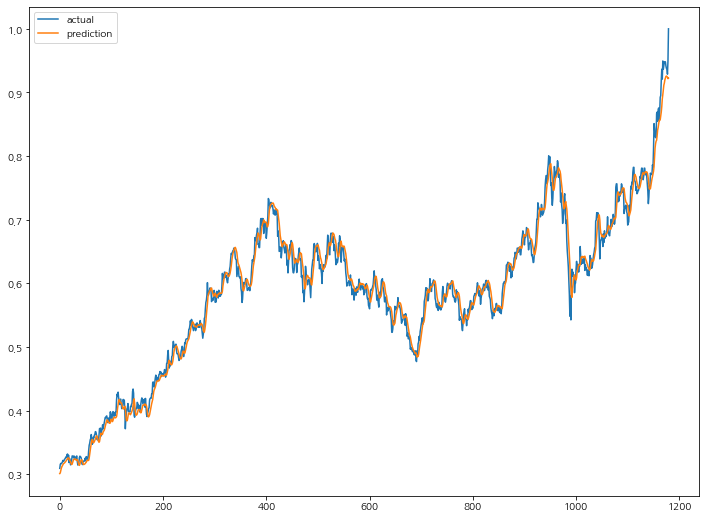

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [42]:
i

3